# Bengali.AI EfficientNet training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
# !pip install pretrainedmodels
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

# PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
# FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='efficientnet-b3'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('efficientnet-b3_1e-3_imagenet')

TH = 40.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 32.3 s, sys: 30.3 s, total: 1min 2s
Wall time: 6.81 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('EfficientNet', 1064),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('FEATHER_PATH', 104),
 ('indices', 104),
 ('PATH', 98),
 ('dirname', 98),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 64),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('TH', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

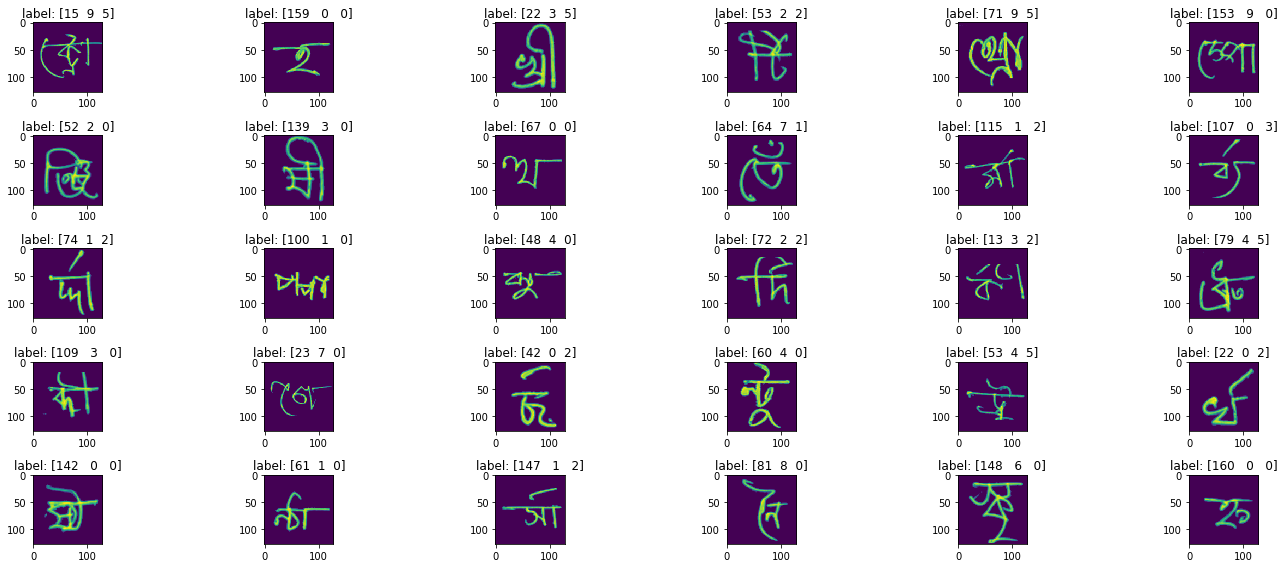

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.08
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def crop_char_image_new(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0 > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

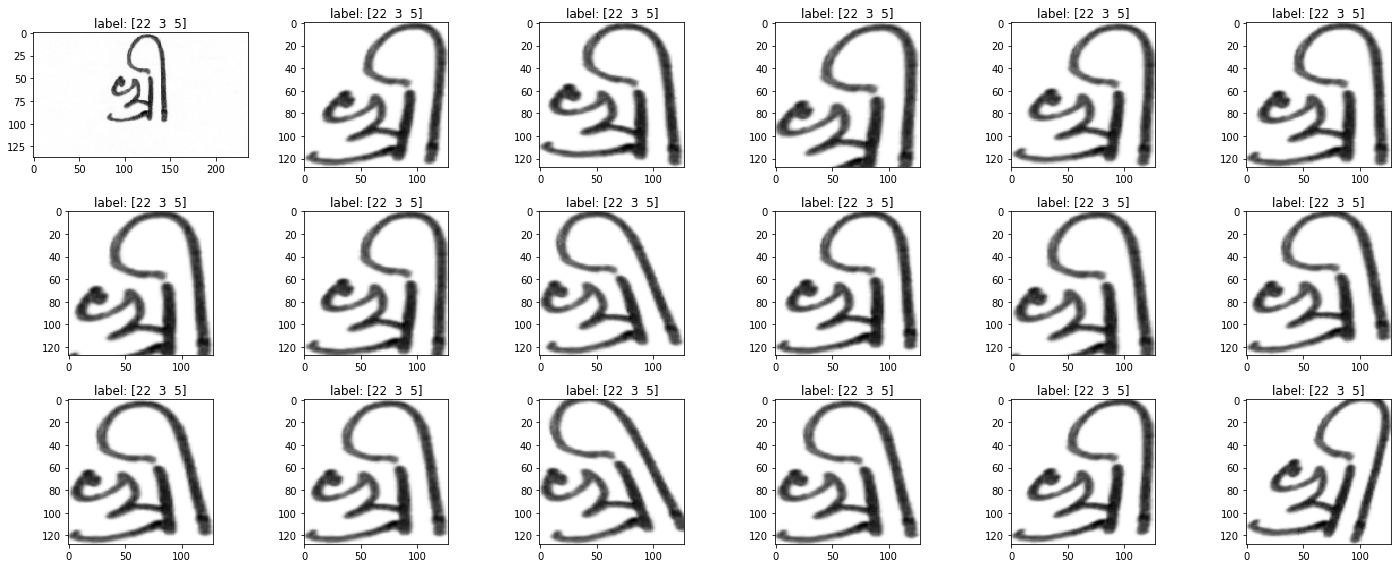

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

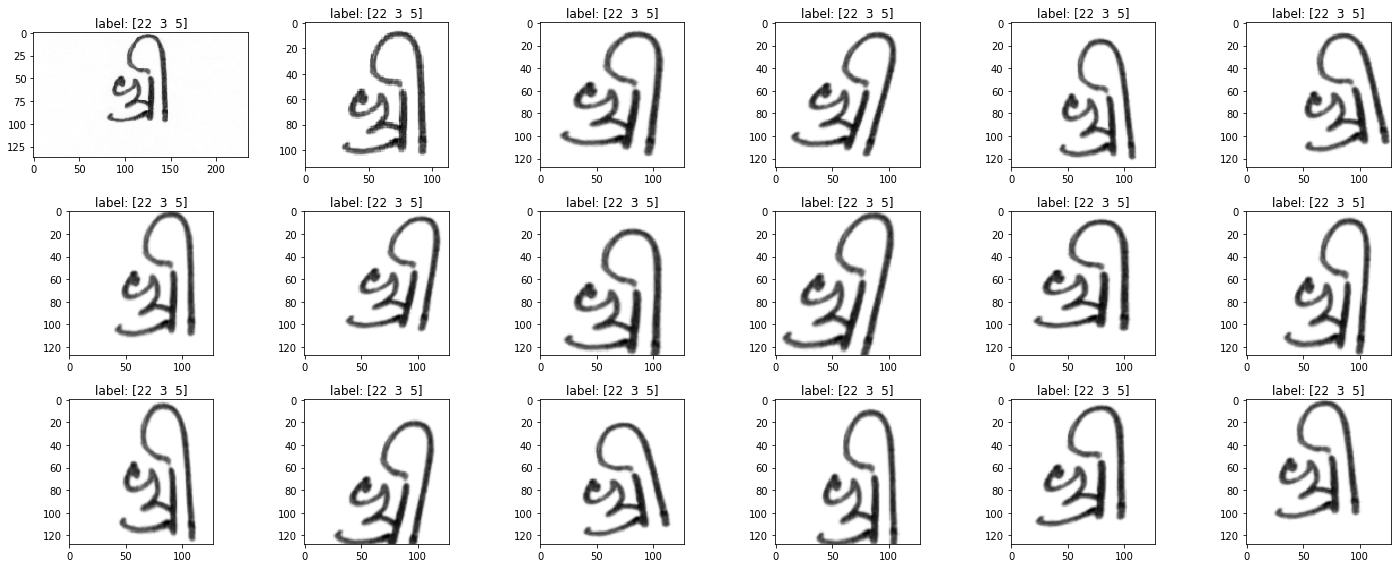

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

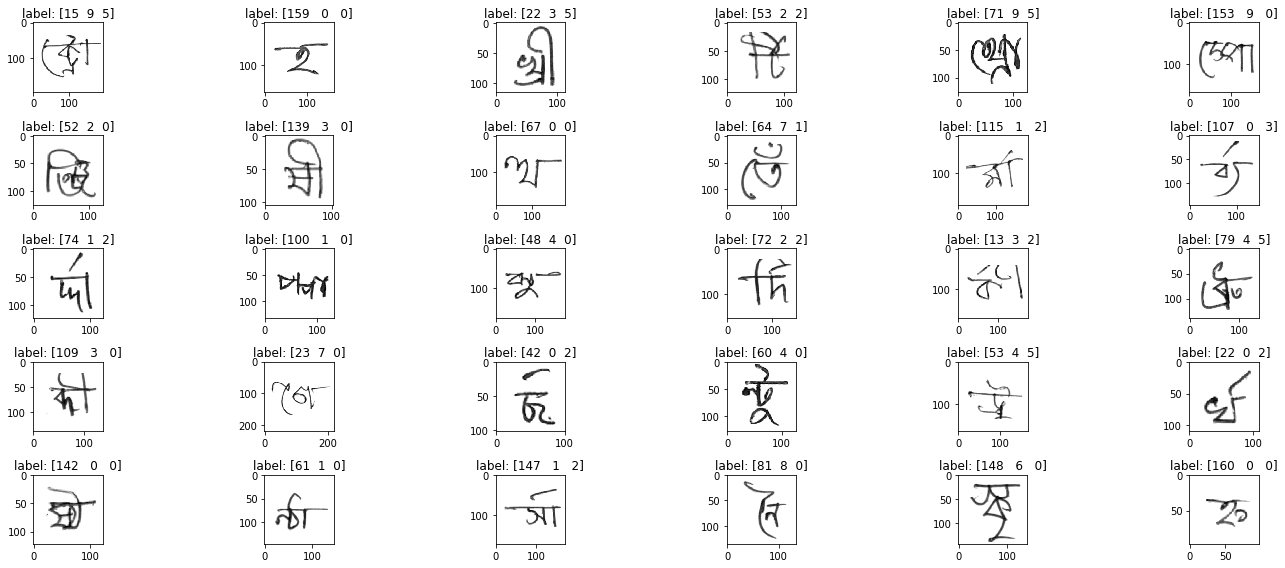

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

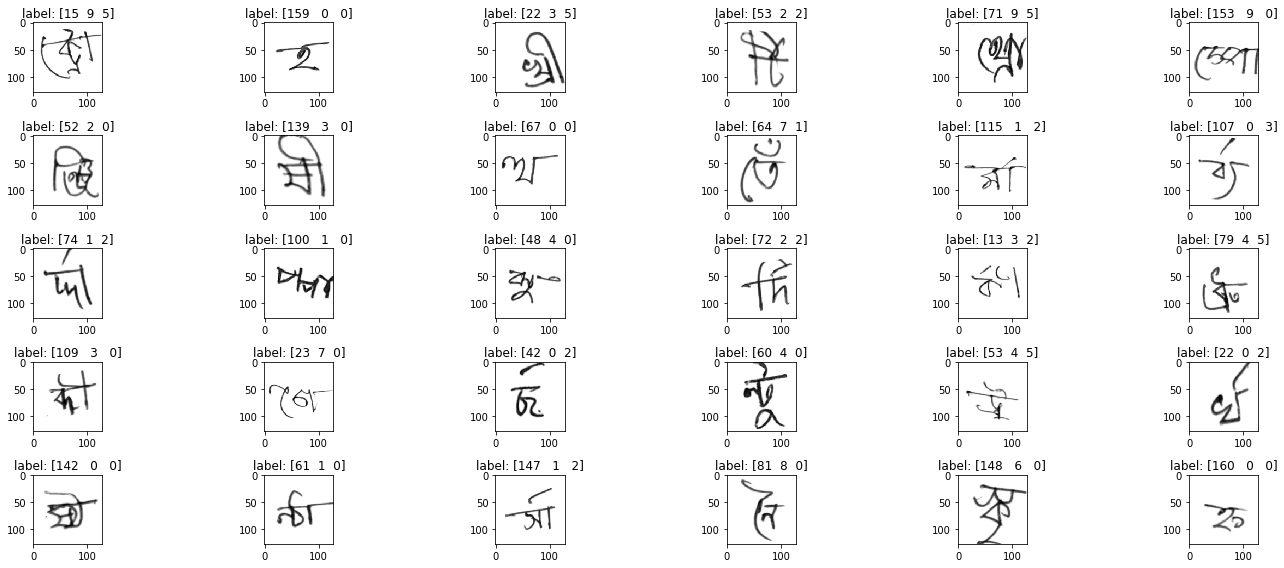

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=32, max_w_size=32, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
    piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

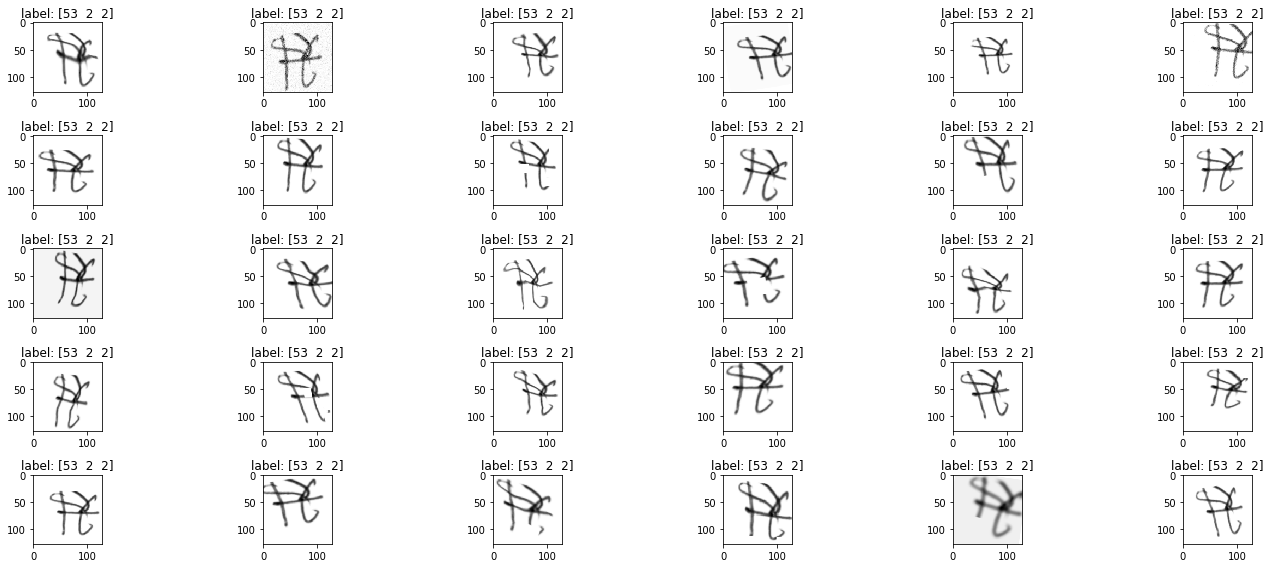

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

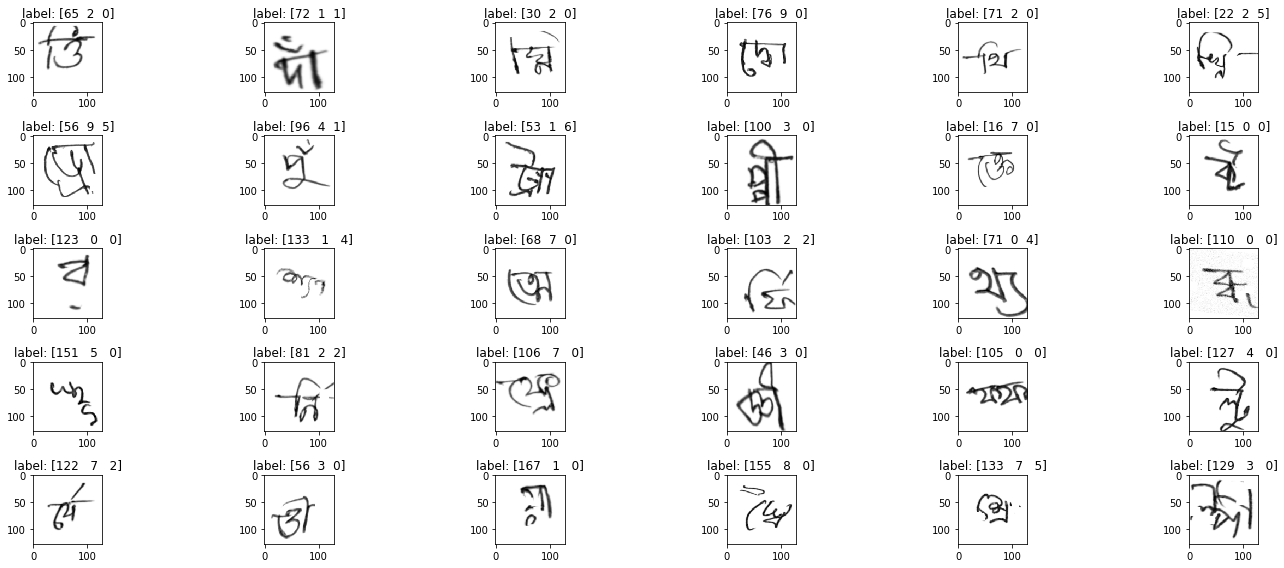

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

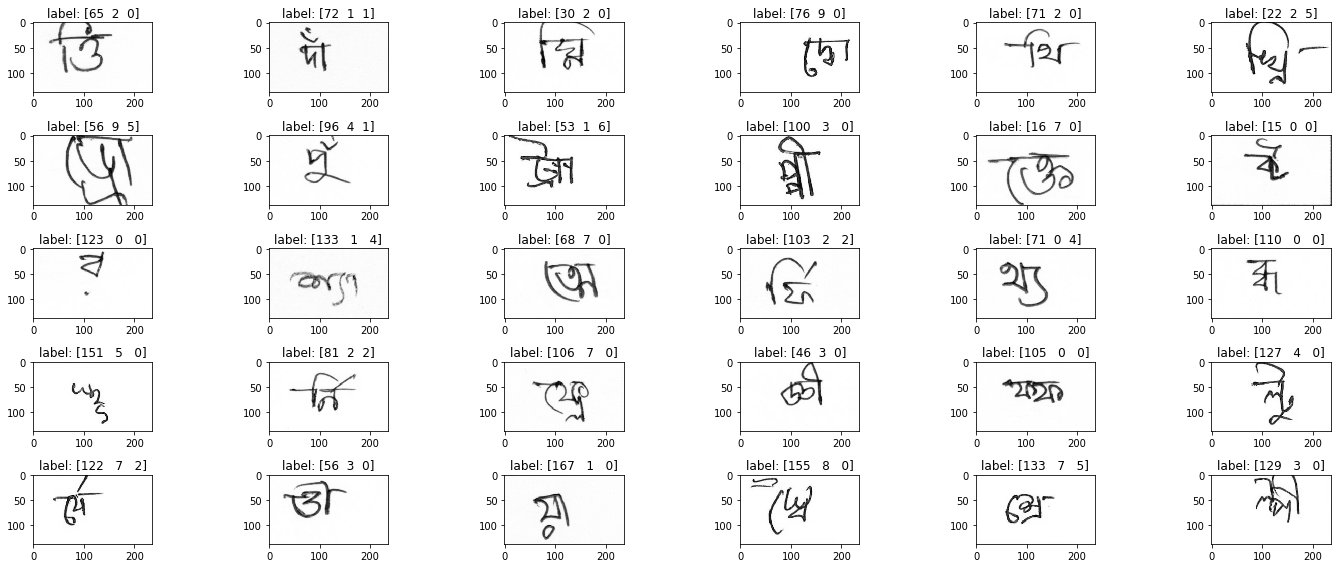

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 1000, dropout_ratio=0.0):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

In [34]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [35]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [36]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='efficientnet-b0',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet', dropout_ratio=0.0):
        super(PretrainedCNN, self).__init__()
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        self.base_model = EfficientNet.from_pretrained(model_name)
    
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model._fc.in_features
        else:
            inch = None
        
        hdim = 1024
        self.classifer = ClassifierNew(inp = inch, h1=hdim, out = out_dim, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

#     def extract_features(self, inputs):
#         """ Returns output of the final convolution layer """

#         # Stem
#         x = self.base_model._swish(self.base_model._bn0(self.base_model._conv_stem(inputs)))

#         # Blocks
#         for idx, block in enumerate(self.base_model._blocks):
#             drop_connect_rate = self.base_model._global_params.drop_connect_rate
#             if drop_connect_rate:
#                 drop_connect_rate *= float(idx) / len(self.base_model._blocks)
#             x = block(x, drop_connect_rate=drop_connect_rate)

#         # Head
#         x = self.base_model._swish(self.base_model._bn1(self.base_model._conv_head(x)))

#         return x

    def forward(self, x):
        x = torch.cat((x,x,x),dim=1)
        h = self.base_model.extract_features(x)
        h = self.classifer(h)
#         if self.do_pooling:
#             h = torch.sum(h, dim=(-1, -2))
            
#         else:
#             # [128, 2048, 4, 4] when input is (128, 128)
#             bs, ch, height, width = h.shape
#             h = h.view(bs, ch*height*width)
#         for layer in self.lin_layers:
#             h = layer(h)

        return h

In [37]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [38]:
# print_grad_status(predictortmp)

In [39]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [40]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [41]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [42]:
# efficientNettmp =  EfficientNet.from_pretrained(model_name)
# for name, child in efficientNettmp.named_children():
#     print(name)
# print(efficientNettmp)

In [43]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [44]:
print(model_name)
predictortmp = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")

efficientnet-b3
Loaded pretrained weights for efficientnet-b3


In [45]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    base_params_list = list(map(id, classifier.predictor.base_model.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params_list,
                     classifier.parameters())
    
    base_params = classifier.predictor.base_model.parameters()
    lr_10 = max(learning_rate/10, 5e-6)
    
    optimizer = torch.optim.Adam(
    [
        dict(params=base_params, lr=lr_10),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [46]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 0.5*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = 0.25*F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = 0.25*F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [47]:
classifiertmp = BengaliClassifier(predictortmp).to(device)
# for name, child in classifiertmp.named_children():
#     print(name)
# optimizertmp = get_optimizer_adam(classifiertmp)
# print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# pc0tmp_params = list(map(id, predictortmp.conv0.parameters()))
# print(len(pc0tmp_params))

opt_tmp = get_optimizer_adam(classifiertmp)
print(opt_tmp)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0
)


<a id="train"></a>
# Training code


In [48]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [49]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [50]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [51]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [52]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [53]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [54]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [55]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [56]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [57]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [58]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
debug = False
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-4)
    optimizer = get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

  0%|          | 0/1674 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3
predictor <class '__main__.PretrainedCNN'>


/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  1.026432 train/loss_grapheme  0.791729 train/loss_vowel  0.129995 train/loss_consonant  0.104708 train/acc_grapheme  0.592667 train/acc_vowel  0.825022 train/acc_consonant  0.855725 train/recall  0.630545 val/loss  0.285582 val/loss_grapheme  0.220565 val/loss_vowel  0.032501 val/loss_consonant  0.032517 val/acc_grapheme  0.870793 val/acc_vowel  0.961661 val/acc_consonant  0.958201 val/recall  0.871596 lr  0.000100 elapsed_time  1159.003638 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  0.391816 train/loss_grapheme  0.296712 train/loss_vowel  0.050094 train/loss_consonant  0.045011 train/acc_grapheme  0.826597 train/acc_vowel  0.937643 train/acc_consonant  0.941496 train/recall  0.825892 val/loss  0.206558 val/loss_grapheme  0.157441 val/loss_vowel  0.025518 val/loss_consonant  0.023599 val/acc_grapheme  0.906244 val/acc_vowel  0.971769 val/acc_consonant  0.969652 val/recall  0.903908 lr  0.000100 elapsed_time  2319.071588 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.304725 train/loss_grapheme  0.228777 train/loss_vowel  0.039378 train/loss_consonant  0.036571 train/acc_grapheme  0.866100 train/acc_vowel  0.952275 train/acc_consonant  0.953595 train/recall  0.863315 val/loss  0.175683 val/loss_grapheme  0.135214 val/loss_vowel  0.020393 val/loss_consonant  0.020075 val/acc_grapheme  0.921007 val/acc_vowel  0.977768 val/acc_consonant  0.975901 val/recall  0.918027 lr  0.000100 elapsed_time  3482.976703 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.261689 train/loss_grapheme  0.195833 train/loss_vowel  0.034104 train/loss_consonant  0.031752 train/acc_grapheme  0.884566 train/acc_vowel  0.959352 train/acc_consonant  0.959931 train/recall  0.879409 val/loss  0.161477 val/loss_grapheme  0.125138 val/loss_vowel  0.018217 val/loss_consonant  0.018123 val/acc_grapheme  0.926882 val/acc_vowel  0.981204 val/acc_consonant  0.978590 val/recall  0.924593 lr  0.000100 elapsed_time  4648.707603 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.231723 train/loss_grapheme  0.172695 train/loss_vowel  0.030273 train/loss_consonant  0.028756 train/acc_grapheme  0.898763 train/acc_vowel  0.964985 train/acc_consonant  0.964244 train/recall  0.894141 val/loss  0.149839 val/loss_grapheme  0.114414 val/loss_vowel  0.018251 val/loss_consonant  0.017175 val/acc_grapheme  0.933703 val/acc_vowel  0.980631 val/acc_consonant  0.980308 val/recall  0.930585 lr  0.000100 elapsed_time  5817.358107 mode 011 


100%|██████████| 419/419 [01:40<00:00,  4.17it/s]


epoch      5 train/loss  0.213539 train/loss_grapheme  0.158662 train/loss_vowel  0.028257 train/loss_consonant  0.026620 train/acc_grapheme  0.906947 train/acc_vowel  0.967306 train/acc_consonant  0.966690 train/recall  0.902366 val/loss  0.145806 val/loss_grapheme  0.111052 val/loss_vowel  0.017168 val/loss_consonant  0.017586 val/acc_grapheme  0.936044 val/acc_vowel  0.982449 val/acc_consonant  0.979312 val/recall  0.932773 lr  0.000100 elapsed_time  6983.148625 mode 011 


100%|██████████| 419/419 [01:40<00:00,  4.18it/s]


epoch      6 train/loss  0.200690 train/loss_grapheme  0.149303 train/loss_vowel  0.026529 train/loss_consonant  0.024858 train/acc_grapheme  0.912069 train/acc_vowel  0.969285 train/acc_consonant  0.969254 train/recall  0.907300 val/loss  0.143711 val/loss_grapheme  0.108786 val/loss_vowel  0.018091 val/loss_consonant  0.016833 val/acc_grapheme  0.937438 val/acc_vowel  0.980084 val/acc_consonant  0.980133 val/recall  0.934694 lr  0.000100 elapsed_time  8148.411234 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.188910 train/loss_grapheme  0.140102 train/loss_vowel  0.024933 train/loss_consonant  0.023875 train/acc_grapheme  0.916613 train/acc_vowel  0.971134 train/acc_consonant  0.970387 train/recall  0.911098 val/loss  0.132012 val/loss_grapheme  0.100953 val/loss_vowel  0.015115 val/loss_consonant  0.015945 val/acc_grapheme  0.941894 val/acc_vowel  0.984864 val/acc_consonant  0.981752 val/recall  0.940747 lr  0.000100 elapsed_time  9318.600533 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.180642 train/loss_grapheme  0.133474 train/loss_vowel  0.024120 train/loss_consonant  0.023048 train/acc_grapheme  0.920310 train/acc_vowel  0.972509 train/acc_consonant  0.971937 train/recall  0.915342 val/loss  0.132962 val/loss_grapheme  0.101168 val/loss_vowel  0.016250 val/loss_consonant  0.015544 val/acc_grapheme  0.941869 val/acc_vowel  0.983395 val/acc_consonant  0.982225 val/recall  0.940210 lr  0.000100 elapsed_time  10481.082871 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.173707 train/loss_grapheme  0.128684 train/loss_vowel  0.022914 train/loss_consonant  0.022110 train/acc_grapheme  0.923285 train/acc_vowel  0.973766 train/acc_consonant  0.972833 train/recall  0.918794 val/loss  0.130345 val/loss_grapheme  0.100207 val/loss_vowel  0.015331 val/loss_consonant  0.014807 val/acc_grapheme  0.942143 val/acc_vowel  0.984316 val/acc_consonant  0.983220 val/recall  0.940809 lr  0.000100 elapsed_time  11650.814618 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.168099 train/loss_grapheme  0.123738 train/loss_vowel  0.023045 train/loss_consonant  0.021317 train/acc_grapheme  0.927430 train/acc_vowel  0.973916 train/acc_consonant  0.973704 train/recall  0.922123 val/loss  0.125636 val/loss_grapheme  0.094618 val/loss_vowel  0.015462 val/loss_consonant  0.015557 val/acc_grapheme  0.946052 val/acc_vowel  0.984938 val/acc_consonant  0.982797 val/recall  0.944211 lr  0.000100 elapsed_time  12815.126070 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.162013 train/loss_grapheme  0.119059 train/loss_vowel  0.022095 train/loss_consonant  0.020859 train/acc_grapheme  0.928563 train/acc_vowel  0.974837 train/acc_consonant  0.973991 train/recall  0.922538 val/loss  0.129650 val/loss_grapheme  0.098300 val/loss_vowel  0.015047 val/loss_consonant  0.016304 val/acc_grapheme  0.942790 val/acc_vowel  0.985038 val/acc_consonant  0.981951 val/recall  0.941463 lr  0.000100 elapsed_time  13978.319805 mode 000 


100%|██████████| 419/419 [01:41<00:00,  4.11it/s]


epoch     12 train/loss  0.159377 train/loss_grapheme  0.117465 train/loss_vowel  0.021644 train/loss_consonant  0.020267 train/acc_grapheme  0.930542 train/acc_vowel  0.974775 train/acc_consonant  0.975416 train/recall  0.925613 val/loss  0.123724 val/loss_grapheme  0.094648 val/loss_vowel  0.014741 val/loss_consonant  0.014335 val/acc_grapheme  0.945927 val/acc_vowel  0.985984 val/acc_consonant  0.984042 val/recall  0.944877 lr  0.000100 elapsed_time  15153.933386 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.153834 train/loss_grapheme  0.112557 train/loss_vowel  0.021396 train/loss_consonant  0.019880 train/acc_grapheme  0.932981 train/acc_vowel  0.975621 train/acc_consonant  0.975372 train/recall  0.926849 val/loss  0.123836 val/loss_grapheme  0.094701 val/loss_vowel  0.014583 val/loss_consonant  0.014552 val/acc_grapheme  0.946923 val/acc_vowel  0.985710 val/acc_consonant  0.983992 val/recall  0.944947 lr  0.000100 elapsed_time  16316.240173 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.150353 train/loss_grapheme  0.110309 train/loss_vowel  0.020672 train/loss_consonant  0.019373 train/acc_grapheme  0.933759 train/acc_vowel  0.976374 train/acc_consonant  0.976667 train/recall  0.927915 val/loss  0.120087 val/loss_grapheme  0.091323 val/loss_vowel  0.014422 val/loss_consonant  0.014342 val/acc_grapheme  0.948566 val/acc_vowel  0.985187 val/acc_consonant  0.983743 val/recall  0.945788 lr  0.000100 elapsed_time  17485.754167 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.148421 train/loss_grapheme  0.108715 train/loss_vowel  0.020179 train/loss_consonant  0.019527 train/acc_grapheme  0.935415 train/acc_vowel  0.976947 train/acc_consonant  0.976275 train/recall  0.930295 val/loss  0.118888 val/loss_grapheme  0.090109 val/loss_vowel  0.014309 val/loss_consonant  0.014470 val/acc_grapheme  0.948865 val/acc_vowel  0.986233 val/acc_consonant  0.983420 val/recall  0.946358 lr  0.000100 elapsed_time  18650.752899 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.144193 train/loss_grapheme  0.105721 train/loss_vowel  0.019937 train/loss_consonant  0.018535 train/acc_grapheme  0.936423 train/acc_vowel  0.977022 train/acc_consonant  0.977370 train/recall  0.931176 val/loss  0.119266 val/loss_grapheme  0.091192 val/loss_vowel  0.014178 val/loss_consonant  0.013897 val/acc_grapheme  0.948392 val/acc_vowel  0.985710 val/acc_consonant  0.983718 val/recall  0.946526 lr  0.000100 elapsed_time  19821.245410 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.142197 train/loss_grapheme  0.103808 train/loss_vowel  0.019723 train/loss_consonant  0.018666 train/acc_grapheme  0.937892 train/acc_vowel  0.977389 train/acc_consonant  0.977395 train/recall  0.932310 val/loss  0.115436 val/loss_grapheme  0.088335 val/loss_vowel  0.013516 val/loss_consonant  0.013584 val/acc_grapheme  0.950583 val/acc_vowel  0.986855 val/acc_consonant  0.984117 val/recall  0.948532 lr  0.000100 elapsed_time  20986.115486 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.139516 train/loss_grapheme  0.101354 train/loss_vowel  0.019797 train/loss_consonant  0.018365 train/acc_grapheme  0.939591 train/acc_vowel  0.977358 train/acc_consonant  0.977289 train/recall  0.933960 val/loss  0.115010 val/loss_grapheme  0.086622 val/loss_vowel  0.014390 val/loss_consonant  0.013998 val/acc_grapheme  0.950383 val/acc_vowel  0.985486 val/acc_consonant  0.984391 val/recall  0.947244 lr  0.000100 elapsed_time  22157.292260 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.139964 train/loss_grapheme  0.102147 train/loss_vowel  0.019588 train/loss_consonant  0.018229 train/acc_grapheme  0.938795 train/acc_vowel  0.977544 train/acc_consonant  0.977837 train/recall  0.933589 val/loss  0.115106 val/loss_grapheme  0.086927 val/loss_vowel  0.013450 val/loss_consonant  0.014729 val/acc_grapheme  0.949910 val/acc_vowel  0.986830 val/acc_consonant  0.983121 val/recall  0.947285 lr  0.000100 elapsed_time  23322.532212 mode 100 


100%|██████████| 419/419 [01:40<00:00,  4.16it/s]


epoch     20 train/loss  0.136289 train/loss_grapheme  0.099223 train/loss_vowel  0.018902 train/loss_consonant  0.018164 train/acc_grapheme  0.940967 train/acc_vowel  0.978497 train/acc_consonant  0.977930 train/recall  0.935237 val/loss  0.114971 val/loss_grapheme  0.087088 val/loss_vowel  0.013935 val/loss_consonant  0.013948 val/acc_grapheme  0.950110 val/acc_vowel  0.986457 val/acc_consonant  0.984465 val/recall  0.948178 lr  0.000100 elapsed_time  24488.860948 mode 010 


100%|██████████| 419/419 [01:39<00:00,  4.22it/s]


epoch     21 train/loss  0.136105 train/loss_grapheme  0.098739 train/loss_vowel  0.019172 train/loss_consonant  0.018194 train/acc_grapheme  0.941041 train/acc_vowel  0.978055 train/acc_consonant  0.977887 train/recall  0.934947 val/loss  0.117466 val/loss_grapheme  0.089982 val/loss_vowel  0.013877 val/loss_consonant  0.013607 val/acc_grapheme  0.949587 val/acc_vowel  0.986083 val/acc_consonant  0.984988 val/recall  0.946931 lr  0.000100 elapsed_time  25655.507476 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.134248 train/loss_grapheme  0.097299 train/loss_vowel  0.019255 train/loss_consonant  0.017695 train/acc_grapheme  0.942012 train/acc_vowel  0.978422 train/acc_consonant  0.978509 train/recall  0.936836 val/loss  0.117424 val/loss_grapheme  0.089878 val/loss_vowel  0.014007 val/loss_consonant  0.013538 val/acc_grapheme  0.950483 val/acc_vowel  0.986283 val/acc_consonant  0.985237 val/recall  0.948610 lr  0.000100 elapsed_time  26825.323546 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.132437 train/loss_grapheme  0.096077 train/loss_vowel  0.018959 train/loss_consonant  0.017401 train/acc_grapheme  0.942473 train/acc_vowel  0.978223 train/acc_consonant  0.978764 train/recall  0.936865 val/loss  0.112423 val/loss_grapheme  0.085620 val/loss_vowel  0.013125 val/loss_consonant  0.013677 val/acc_grapheme  0.950981 val/acc_vowel  0.987104 val/acc_consonant  0.985386 val/recall  0.948318 lr  0.000100 elapsed_time  27997.247487 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.132066 train/loss_grapheme  0.095769 train/loss_vowel  0.018718 train/loss_consonant  0.017579 train/acc_grapheme  0.943027 train/acc_vowel  0.978733 train/acc_consonant  0.978073 train/recall  0.937655 val/loss  0.115338 val/loss_grapheme  0.087967 val/loss_vowel  0.013786 val/loss_consonant  0.013585 val/acc_grapheme  0.950085 val/acc_vowel  0.985760 val/acc_consonant  0.985312 val/recall  0.946733 lr  0.000100 elapsed_time  29165.372611 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.129987 train/loss_grapheme  0.094563 train/loss_vowel  0.018186 train/loss_consonant  0.017238 train/acc_grapheme  0.943618 train/acc_vowel  0.979212 train/acc_consonant  0.978951 train/recall  0.938492 val/loss  0.115247 val/loss_grapheme  0.088083 val/loss_vowel  0.013706 val/loss_consonant  0.013458 val/acc_grapheme  0.950607 val/acc_vowel  0.986855 val/acc_consonant  0.984864 val/recall  0.947887 lr  0.000100 elapsed_time  30336.447128 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.128936 train/loss_grapheme  0.093171 train/loss_vowel  0.018446 train/loss_consonant  0.017319 train/acc_grapheme  0.944253 train/acc_vowel  0.979032 train/acc_consonant  0.979044 train/recall  0.939247 val/loss  0.113424 val/loss_grapheme  0.086162 val/loss_vowel  0.013406 val/loss_consonant  0.013855 val/acc_grapheme  0.951429 val/acc_vowel  0.987054 val/acc_consonant  0.985013 val/recall  0.949067 lr  0.000100 elapsed_time  31507.587511 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.127066 train/loss_grapheme  0.091555 train/loss_vowel  0.018249 train/loss_consonant  0.017262 train/acc_grapheme  0.945989 train/acc_vowel  0.979051 train/acc_consonant  0.979324 train/recall  0.940546 val/loss  0.111087 val/loss_grapheme  0.083081 val/loss_vowel  0.014212 val/loss_consonant  0.013795 val/acc_grapheme  0.953246 val/acc_vowel  0.986432 val/acc_consonant  0.984391 val/recall  0.950061 lr  0.000100 elapsed_time  32675.364325 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.125002 train/loss_grapheme  0.090131 train/loss_vowel  0.018291 train/loss_consonant  0.016580 train/acc_grapheme  0.946431 train/acc_vowel  0.979268 train/acc_consonant  0.979772 train/recall  0.940808 val/loss  0.112682 val/loss_grapheme  0.085779 val/loss_vowel  0.013384 val/loss_consonant  0.013519 val/acc_grapheme  0.952649 val/acc_vowel  0.987328 val/acc_consonant  0.985088 val/recall  0.949352 lr  0.000100 elapsed_time  33845.364002 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.125366 train/loss_grapheme  0.090502 train/loss_vowel  0.018013 train/loss_consonant  0.016850 train/acc_grapheme  0.946207 train/acc_vowel  0.979791 train/acc_consonant  0.979511 train/recall  0.940887 val/loss  0.114133 val/loss_grapheme  0.086309 val/loss_vowel  0.013452 val/loss_consonant  0.014372 val/acc_grapheme  0.951603 val/acc_vowel  0.986532 val/acc_consonant  0.983793 val/recall  0.947708 lr  0.000100 elapsed_time  35014.594404 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.124890 train/loss_grapheme  0.089883 train/loss_vowel  0.017968 train/loss_consonant  0.017039 train/acc_grapheme  0.946045 train/acc_vowel  0.979436 train/acc_consonant  0.979225 train/recall  0.940928 val/loss  0.116893 val/loss_grapheme  0.088942 val/loss_vowel  0.013613 val/loss_consonant  0.014337 val/acc_grapheme  0.950234 val/acc_vowel  0.987428 val/acc_consonant  0.984366 val/recall  0.948035 lr  0.000100 elapsed_time  36185.176691 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.123351 train/loss_grapheme  0.088980 train/loss_vowel  0.017710 train/loss_consonant  0.016661 train/acc_grapheme  0.946973 train/acc_vowel  0.980146 train/acc_consonant  0.979561 train/recall  0.941882 val/loss  0.114796 val/loss_grapheme  0.086027 val/loss_vowel  0.014459 val/loss_consonant  0.014310 val/acc_grapheme  0.951802 val/acc_vowel  0.985760 val/acc_consonant  0.983370 val/recall  0.948313 lr  0.000100 elapsed_time  37358.185241 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.122712 train/loss_grapheme  0.088089 train/loss_vowel  0.017916 train/loss_consonant  0.016707 train/acc_grapheme  0.947234 train/acc_vowel  0.980003 train/acc_consonant  0.979698 train/recall  0.941740 val/loss  0.111664 val/loss_grapheme  0.084992 val/loss_vowel  0.013175 val/loss_consonant  0.013497 val/acc_grapheme  0.951902 val/acc_vowel  0.986905 val/acc_consonant  0.985411 val/recall  0.949927 lr  0.000100 elapsed_time  38529.633999 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.121536 train/loss_grapheme  0.087289 train/loss_vowel  0.017682 train/loss_consonant  0.016565 train/acc_grapheme  0.947969 train/acc_vowel  0.979754 train/acc_consonant  0.979524 train/recall  0.941523 val/loss  0.112427 val/loss_grapheme  0.085717 val/loss_vowel  0.013291 val/loss_consonant  0.013420 val/acc_grapheme  0.952226 val/acc_vowel  0.987428 val/acc_consonant  0.985162 val/recall  0.949297 lr  0.000100 elapsed_time  39700.312333 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.120995 train/loss_grapheme  0.087389 train/loss_vowel  0.017295 train/loss_consonant  0.016311 train/acc_grapheme  0.947844 train/acc_vowel  0.980102 train/acc_consonant  0.979916 train/recall  0.942150 val/loss  0.111669 val/loss_grapheme  0.084564 val/loss_vowel  0.013326 val/loss_consonant  0.013780 val/acc_grapheme  0.952973 val/acc_vowel  0.987403 val/acc_consonant  0.985137 val/recall  0.950541 lr  0.000100 elapsed_time  40873.599451 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.120153 train/loss_grapheme  0.086482 train/loss_vowel  0.017483 train/loss_consonant  0.016189 train/acc_grapheme  0.948292 train/acc_vowel  0.980127 train/acc_consonant  0.980283 train/recall  0.942309 val/loss  0.117705 val/loss_grapheme  0.090329 val/loss_vowel  0.013756 val/loss_consonant  0.013620 val/acc_grapheme  0.949512 val/acc_vowel  0.986606 val/acc_consonant  0.984938 val/recall  0.947907 lr  0.000100 elapsed_time  42051.949941 mode 000 


100%|██████████| 419/419 [01:41<00:00,  4.12it/s]


epoch     36 train/loss  0.120703 train/loss_grapheme  0.087258 train/loss_vowel  0.017071 train/loss_consonant  0.016374 train/acc_grapheme  0.947894 train/acc_vowel  0.980694 train/acc_consonant  0.980382 train/recall  0.942530 val/loss  0.111960 val/loss_grapheme  0.085139 val/loss_vowel  0.013552 val/loss_consonant  0.013269 val/acc_grapheme  0.952475 val/acc_vowel  0.986382 val/acc_consonant  0.985710 val/recall  0.949909 lr  0.000100 elapsed_time  43229.417681 mode 000 


100%|██████████| 419/419 [01:41<00:00,  4.14it/s]


epoch     37 train/loss  0.118508 train/loss_grapheme  0.085250 train/loss_vowel  0.017219 train/loss_consonant  0.016038 train/acc_grapheme  0.948647 train/acc_vowel  0.980501 train/acc_consonant  0.980189 train/recall  0.943405 val/loss  0.109862 val/loss_grapheme  0.083649 val/loss_vowel  0.012837 val/loss_consonant  0.013376 val/acc_grapheme  0.952524 val/acc_vowel  0.987428 val/acc_consonant  0.985461 val/recall  0.950253 lr  0.000100 elapsed_time  44404.462581 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.118221 train/loss_grapheme  0.085297 train/loss_vowel  0.016906 train/loss_consonant  0.016018 train/acc_grapheme  0.949325 train/acc_vowel  0.980588 train/acc_consonant  0.980295 train/recall  0.943526 val/loss  0.113928 val/loss_grapheme  0.086314 val/loss_vowel  0.013600 val/loss_consonant  0.014014 val/acc_grapheme  0.951653 val/acc_vowel  0.986805 val/acc_consonant  0.984789 val/recall  0.950239 lr  0.000100 elapsed_time  45575.318393 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.116597 train/loss_grapheme  0.083587 train/loss_vowel  0.017158 train/loss_consonant  0.015852 train/acc_grapheme  0.949960 train/acc_vowel  0.980395 train/acc_consonant  0.980600 train/recall  0.944088 val/loss  0.110200 val/loss_grapheme  0.083576 val/loss_vowel  0.013467 val/loss_consonant  0.013157 val/acc_grapheme  0.953744 val/acc_vowel  0.986706 val/acc_consonant  0.985561 val/recall  0.951148 lr  0.000100 elapsed_time  46750.826508 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.117483 train/loss_grapheme  0.084467 train/loss_vowel  0.016809 train/loss_consonant  0.016206 train/acc_grapheme  0.948977 train/acc_vowel  0.980868 train/acc_consonant  0.980519 train/recall  0.943547 val/loss  0.109678 val/loss_grapheme  0.082978 val/loss_vowel  0.013696 val/loss_consonant  0.013004 val/acc_grapheme  0.954740 val/acc_vowel  0.986830 val/acc_consonant  0.985685 val/recall  0.952295 lr  0.000100 elapsed_time  47918.822957 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.116118 train/loss_grapheme  0.082987 train/loss_vowel  0.016953 train/loss_consonant  0.016179 train/acc_grapheme  0.949848 train/acc_vowel  0.980376 train/acc_consonant  0.980532 train/recall  0.943514 val/loss  0.111496 val/loss_grapheme  0.083572 val/loss_vowel  0.013181 val/loss_consonant  0.014743 val/acc_grapheme  0.954342 val/acc_vowel  0.986855 val/acc_consonant  0.982872 val/recall  0.951937 lr  0.000100 elapsed_time  49093.278363 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.116447 train/loss_grapheme  0.083287 train/loss_vowel  0.017256 train/loss_consonant  0.015904 train/acc_grapheme  0.949848 train/acc_vowel  0.980862 train/acc_consonant  0.980706 train/recall  0.944462 val/loss  0.115584 val/loss_grapheme  0.088486 val/loss_vowel  0.013716 val/loss_consonant  0.013382 val/acc_grapheme  0.951180 val/acc_vowel  0.986532 val/acc_consonant  0.985287 val/recall  0.950154 lr  0.000100 elapsed_time  50267.761920 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.114586 train/loss_grapheme  0.081841 train/loss_vowel  0.016605 train/loss_consonant  0.016140 train/acc_grapheme  0.951180 train/acc_vowel  0.981011 train/acc_consonant  0.980382 train/recall  0.945077 val/loss  0.113645 val/loss_grapheme  0.087071 val/loss_vowel  0.013090 val/loss_consonant  0.013484 val/acc_grapheme  0.951155 val/acc_vowel  0.987104 val/acc_consonant  0.985187 val/recall  0.949951 lr  0.000100 elapsed_time  51443.721286 mode 000 


100%|██████████| 419/419 [01:40<00:00,  4.16it/s]


epoch     44 train/loss  0.114396 train/loss_grapheme  0.082145 train/loss_vowel  0.016838 train/loss_consonant  0.015413 train/acc_grapheme  0.950713 train/acc_vowel  0.980725 train/acc_consonant  0.981428 train/recall  0.945189 val/loss  0.114021 val/loss_grapheme  0.086653 val/loss_vowel  0.014226 val/loss_consonant  0.013142 val/acc_grapheme  0.951678 val/acc_vowel  0.985486 val/acc_consonant  0.985660 val/recall  0.948474 lr  0.000100 elapsed_time  52613.816882 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.112825 train/loss_grapheme  0.080729 train/loss_vowel  0.016504 train/loss_consonant  0.015592 train/acc_grapheme  0.952002 train/acc_vowel  0.981291 train/acc_consonant  0.980743 train/recall  0.946873 val/loss  0.110489 val/loss_grapheme  0.083197 val/loss_vowel  0.013890 val/loss_consonant  0.013403 val/acc_grapheme  0.953346 val/acc_vowel  0.986233 val/acc_consonant  0.985337 val/recall  0.949758 lr  0.000100 elapsed_time  53788.657615 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.112861 train/loss_grapheme  0.080698 train/loss_vowel  0.016571 train/loss_consonant  0.015592 train/acc_grapheme  0.952045 train/acc_vowel  0.981136 train/acc_consonant  0.980992 train/recall  0.946828 val/loss  0.109309 val/loss_grapheme  0.082664 val/loss_vowel  0.013108 val/loss_consonant  0.013538 val/acc_grapheme  0.953695 val/acc_vowel  0.987104 val/acc_consonant  0.984938 val/recall  0.950807 lr  0.000100 elapsed_time  54965.037623 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.113387 train/loss_grapheme  0.081322 train/loss_vowel  0.016568 train/loss_consonant  0.015497 train/acc_grapheme  0.951311 train/acc_vowel  0.980967 train/acc_consonant  0.981017 train/recall  0.945132 val/loss  0.109526 val/loss_grapheme  0.082155 val/loss_vowel  0.013609 val/loss_consonant  0.013762 val/acc_grapheme  0.954541 val/acc_vowel  0.986756 val/acc_consonant  0.984789 val/recall  0.951665 lr  0.000100 elapsed_time  56137.612699 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.112416 train/loss_grapheme  0.080210 train/loss_vowel  0.016533 train/loss_consonant  0.015673 train/acc_grapheme  0.951834 train/acc_vowel  0.981185 train/acc_consonant  0.980893 train/recall  0.946314 val/loss  0.108433 val/loss_grapheme  0.081717 val/loss_vowel  0.012923 val/loss_consonant  0.013793 val/acc_grapheme  0.953545 val/acc_vowel  0.986930 val/acc_consonant  0.984515 val/recall  0.951696 lr  0.000100 elapsed_time  57312.664176 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.111284 train/loss_grapheme  0.079425 train/loss_vowel  0.016496 train/loss_consonant  0.015364 train/acc_grapheme  0.952369 train/acc_vowel  0.981030 train/acc_consonant  0.981447 train/recall  0.946399 val/loss  0.107407 val/loss_grapheme  0.081280 val/loss_vowel  0.012759 val/loss_consonant  0.013368 val/acc_grapheme  0.954616 val/acc_vowel  0.987453 val/acc_consonant  0.985610 val/recall  0.952483 lr  0.000100 elapsed_time  58479.845073 mode 111 


100%|██████████| 419/419 [01:40<00:00,  4.18it/s]


epoch     50 train/loss  0.111729 train/loss_grapheme  0.079751 train/loss_vowel  0.016444 train/loss_consonant  0.015534 train/acc_grapheme  0.952139 train/acc_vowel  0.980899 train/acc_consonant  0.981322 train/recall  0.946649 val/loss  0.109830 val/loss_grapheme  0.083426 val/loss_vowel  0.013248 val/loss_consonant  0.013155 val/acc_grapheme  0.954665 val/acc_vowel  0.987527 val/acc_consonant  0.985461 val/recall  0.951367 lr  0.000100 elapsed_time  59645.841223 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.111772 train/loss_grapheme  0.080346 train/loss_vowel  0.016137 train/loss_consonant  0.015289 train/acc_grapheme  0.951877 train/acc_vowel  0.981173 train/acc_consonant  0.981328 train/recall  0.946066 val/loss  0.110145 val/loss_grapheme  0.083387 val/loss_vowel  0.013338 val/loss_consonant  0.013420 val/acc_grapheme  0.953570 val/acc_vowel  0.987005 val/acc_consonant  0.984739 val/recall  0.950393 lr  0.000100 elapsed_time  60815.582648 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.111101 train/loss_grapheme  0.079412 train/loss_vowel  0.016240 train/loss_consonant  0.015449 train/acc_grapheme  0.952387 train/acc_vowel  0.981416 train/acc_consonant  0.981297 train/recall  0.946860 val/loss  0.110932 val/loss_grapheme  0.084063 val/loss_vowel  0.013335 val/loss_consonant  0.013534 val/acc_grapheme  0.953595 val/acc_vowel  0.986781 val/acc_consonant  0.985436 val/recall  0.950297 lr  0.000100 elapsed_time  61990.570974 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.111066 train/loss_grapheme  0.079365 train/loss_vowel  0.016486 train/loss_consonant  0.015215 train/acc_grapheme  0.952593 train/acc_vowel  0.981254 train/acc_consonant  0.981671 train/recall  0.947013 val/loss  0.110224 val/loss_grapheme  0.083660 val/loss_vowel  0.013362 val/loss_consonant  0.013202 val/acc_grapheme  0.953968 val/acc_vowel  0.986905 val/acc_consonant  0.985187 val/recall  0.951207 lr  0.000100 elapsed_time  63157.628070 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.110672 train/loss_grapheme  0.079032 train/loss_vowel  0.016297 train/loss_consonant  0.015344 train/acc_grapheme  0.952587 train/acc_vowel  0.981447 train/acc_consonant  0.981416 train/recall  0.947015 val/loss  0.109436 val/loss_grapheme  0.081726 val/loss_vowel  0.013720 val/loss_consonant  0.013989 val/acc_grapheme  0.954168 val/acc_vowel  0.986880 val/acc_consonant  0.984814 val/recall  0.950737 lr  0.000100 elapsed_time  64328.534051 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.110928 train/loss_grapheme  0.079250 train/loss_vowel  0.016341 train/loss_consonant  0.015337 train/acc_grapheme  0.952624 train/acc_vowel  0.981297 train/acc_consonant  0.980955 train/recall  0.947036 val/loss  0.107798 val/loss_grapheme  0.080142 val/loss_vowel  0.013238 val/loss_consonant  0.014418 val/acc_grapheme  0.955686 val/acc_vowel  0.987079 val/acc_consonant  0.984366 val/recall  0.951151 lr  0.000100 elapsed_time  65490.580896 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.108305 train/loss_grapheme  0.077324 train/loss_vowel  0.015865 train/loss_consonant  0.015116 train/acc_grapheme  0.952904 train/acc_vowel  0.981658 train/acc_consonant  0.981440 train/recall  0.946735 val/loss  0.111543 val/loss_grapheme  0.084411 val/loss_vowel  0.013664 val/loss_consonant  0.013468 val/acc_grapheme  0.952500 val/acc_vowel  0.986631 val/acc_consonant  0.985411 val/recall  0.950753 lr  0.000100 elapsed_time  66655.694887 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.109129 train/loss_grapheme  0.078072 train/loss_vowel  0.015994 train/loss_consonant  0.015063 train/acc_grapheme  0.953545 train/acc_vowel  0.981609 train/acc_consonant  0.981546 train/recall  0.947880 val/loss  0.111925 val/loss_grapheme  0.084378 val/loss_vowel  0.013826 val/loss_consonant  0.013720 val/acc_grapheme  0.954317 val/acc_vowel  0.986208 val/acc_consonant  0.984814 val/recall  0.950585 lr  0.000100 elapsed_time  67824.842744 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.109940 train/loss_grapheme  0.078405 train/loss_vowel  0.016163 train/loss_consonant  0.015372 train/acc_grapheme  0.953427 train/acc_vowel  0.981048 train/acc_consonant  0.981447 train/recall  0.947292 val/loss  0.111081 val/loss_grapheme  0.084725 val/loss_vowel  0.013100 val/loss_consonant  0.013256 val/acc_grapheme  0.951603 val/acc_vowel  0.987602 val/acc_consonant  0.985287 val/recall  0.949401 lr  0.000100 elapsed_time  68987.755331 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.109195 train/loss_grapheme  0.077977 train/loss_vowel  0.015988 train/loss_consonant  0.015230 train/acc_grapheme  0.953688 train/acc_vowel  0.982044 train/acc_consonant  0.981490 train/recall  0.947985 val/loss  0.112114 val/loss_grapheme  0.084947 val/loss_vowel  0.014172 val/loss_consonant  0.012995 val/acc_grapheme  0.952699 val/acc_vowel  0.986432 val/acc_consonant  0.986034 val/recall  0.949947 lr  0.000100 elapsed_time  70147.617889 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.107999 train/loss_grapheme  0.076666 train/loss_vowel  0.016048 train/loss_consonant  0.015286 train/acc_grapheme  0.953881 train/acc_vowel  0.982007 train/acc_consonant  0.981453 train/recall  0.948208 val/loss  0.108287 val/loss_grapheme  0.082256 val/loss_vowel  0.013400 val/loss_consonant  0.012631 val/acc_grapheme  0.955163 val/acc_vowel  0.987278 val/acc_consonant  0.985884 val/recall  0.951400 lr  0.000100 elapsed_time  71308.428652 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.107734 train/loss_grapheme  0.076852 train/loss_vowel  0.015892 train/loss_consonant  0.014990 train/acc_grapheme  0.953850 train/acc_vowel  0.981826 train/acc_consonant  0.981721 train/recall  0.948623 val/loss  0.110837 val/loss_grapheme  0.083933 val/loss_vowel  0.013579 val/loss_consonant  0.013325 val/acc_grapheme  0.954367 val/acc_vowel  0.987005 val/acc_consonant  0.985511 val/recall  0.951589 lr  0.000100 elapsed_time  72469.141298 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.108645 train/loss_grapheme  0.077648 train/loss_vowel  0.015700 train/loss_consonant  0.015297 train/acc_grapheme  0.953676 train/acc_vowel  0.982467 train/acc_consonant  0.981341 train/recall  0.947963 val/loss  0.105085 val/loss_grapheme  0.079047 val/loss_vowel  0.012857 val/loss_consonant  0.013180 val/acc_grapheme  0.956259 val/acc_vowel  0.987602 val/acc_consonant  0.985362 val/recall  0.952828 lr  0.000100 elapsed_time  73629.345941 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.107649 train/loss_grapheme  0.076386 train/loss_vowel  0.016236 train/loss_consonant  0.015027 train/acc_grapheme  0.954921 train/acc_vowel  0.981409 train/acc_consonant  0.981689 train/recall  0.948887 val/loss  0.114516 val/loss_grapheme  0.087375 val/loss_vowel  0.013720 val/loss_consonant  0.013421 val/acc_grapheme  0.952599 val/acc_vowel  0.986581 val/acc_consonant  0.985237 val/recall  0.949397 lr  0.000100 elapsed_time  74788.333999 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.106377 train/loss_grapheme  0.075628 train/loss_vowel  0.015726 train/loss_consonant  0.015024 train/acc_grapheme  0.954952 train/acc_vowel  0.982088 train/acc_consonant  0.981403 train/recall  0.949294 val/loss  0.110804 val/loss_grapheme  0.083777 val/loss_vowel  0.013537 val/loss_consonant  0.013490 val/acc_grapheme  0.953919 val/acc_vowel  0.986805 val/acc_consonant  0.985063 val/recall  0.951424 lr  0.000100 elapsed_time  75947.267725 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.106144 train/loss_grapheme  0.075467 train/loss_vowel  0.015792 train/loss_consonant  0.014886 train/acc_grapheme  0.954410 train/acc_vowel  0.982019 train/acc_consonant  0.982082 train/recall  0.949140 val/loss  0.110096 val/loss_grapheme  0.083681 val/loss_vowel  0.013067 val/loss_consonant  0.013348 val/acc_grapheme  0.954018 val/acc_vowel  0.987503 val/acc_consonant  0.985461 val/recall  0.951387 lr  0.000100 elapsed_time  77105.162133 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.106377 train/loss_grapheme  0.075174 train/loss_vowel  0.016136 train/loss_consonant  0.015067 train/acc_grapheme  0.954547 train/acc_vowel  0.981596 train/acc_consonant  0.981509 train/recall  0.948745 val/loss  0.108931 val/loss_grapheme  0.081707 val/loss_vowel  0.013319 val/loss_consonant  0.013905 val/acc_grapheme  0.954392 val/acc_vowel  0.987129 val/acc_consonant  0.984963 val/recall  0.952099 lr  0.000100 elapsed_time  78265.007437 mode 000 


 64%|██████▍   | 269/419 [01:05<00:36,  4.11it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>